## Identification

Gabriel Kazuyuki | 8908

Juliano Garcia de Oliveira | 9277086

Matheus Tararam de Laurentys | 9793714

## Name of the dataset
Dataset: Women's Shoe Prices

## Abstract
This dataset contains Women's shoe product information, mainly the prices, brands, etc. Interestingly, it also has some images


The original dataset is provided by the Datafiniti company, and as we don't have access to a premium API, I'm using a sample of it, that I found on kaggle. 

## Questions to the dataset
Question 1: Which categories have the highest price?

Question 2: Is there a pattern to the colors depending on the brand or price?

Question 3: Which brands have the lowest ratings?

Question 4: What is the percentage of shoes which the prices changed?

Question 5: What is the number of shoes which there is difference between the minimum and maximum prices?

Question 6: What is the mean of the prices of the shoes added each month of the year?

## EDA

## 0. Importing DataSet, Helper Code and Data Cleanup

In [16]:
from IPython.core.interactiveshell import InteractiveShell #display full output instead of just the last one
InteractiveShell.ast_node_interactivity = "all"

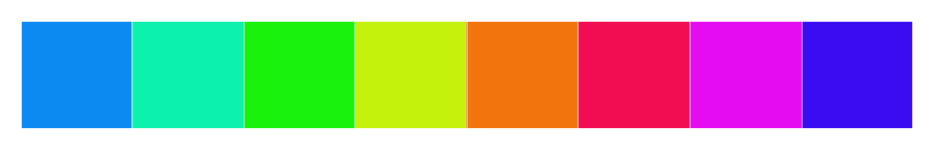

In [17]:
import toolz as fp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import string
from pprint import pprint
sns.set()
%matplotlib inline
pd.set_option('display.max_rows', 50)
palette = sns.hls_palette(8, h=.7, s=.9, l=0.5)
sns.palplot(palette[::-1])
sns.set_palette(palette[::-1])

gray = "444444"

plt.rcParams['figure.facecolor'] = '1'  # background color
plt.rcParams['axes.facecolor'] = '1'  # plot background color

plt.rcParams['grid.color'] = '0.8'
plt.rcParams['grid.alpha'] = .4

plt.rcParams['axes.edgecolor'] = '1'

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['grid.linestyle'] = '-'

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.labelcolor'] = gray

plt.rcParams['text.color'] = gray

plt.rcParams['xtick.color'] = gray
plt.rcParams['ytick.color'] = gray
sns.set_style("whitegrid")
sns.set_context("notebook")
%config InlineBackend.figure_format = "retina"

In [18]:
def new_axis(figsize=(15, 8), title=None):
    """
    Creates a new matplotlib axis and returns it
    Parameters
    ----------
    figsize : Tuple(Numeric, Numeric)
        the figure size
    title : str
        the figure title
    """
    _, ax = plt.subplots(figsize=figsize)
    if title is not None:
        ax.set_title(title, size=17)
    return ax

Import data

In [19]:
df1 = pd.read_csv("womens-shoes-prices/7210_1.csv")
df1.columns = pd.Index(map(lambda c: c.replace(".", "_"), df1.columns)) # replace names for better ones
df1 = df1.drop(columns=[col for col in df1.columns if "Unnamed" in col]) # remove unnamed columns
df1 = df1.query("prices_currency == 'USD'") # remove non USD for simplicity. The majority of the prices are in USD
df1.shape

(32680, 48)

In [20]:
df1.columns

Index(['id', 'asins', 'brand', 'categories', 'colors', 'count', 'dateAdded',
       'dateUpdated', 'descriptions', 'dimension', 'ean', 'features',
       'flavors', 'imageURLs', 'isbn', 'keys', 'manufacturer',
       'manufacturerNumber', 'merchants', 'name', 'prices_amountMin',
       'prices_amountMax', 'prices_availability', 'prices_color',
       'prices_condition', 'prices_count', 'prices_currency',
       'prices_dateAdded', 'prices_dateSeen', 'prices_flavor', 'prices_isSale',
       'prices_merchant', 'prices_offer', 'prices_returnPolicy',
       'prices_shipping', 'prices_size', 'prices_source', 'prices_sourceURLs',
       'prices_warranty', 'quantities', 'reviews', 'sizes', 'skus',
       'sourceURLs', 'upc', 'vin', 'websiteIDs', 'weight'],
      dtype='object')

In [21]:
# Auxiliary methods

def get_review_texts(el):
    try:
        dict_review = json.loads(el)
        return " ENDMSG ".join(map(lambda rev: rev.get("text", ""), dict_review))
    except (TypeError, json.JSONDecodeError, KeyError) as e:
        return np.nan

def get_review_ratings(el):
    try:
        dict_review = json.loads(el)
        reviews_list = list(map(lambda rev: rev.get("rating", np.nan), dict_review))
        if all(np.isnan(reviews_list)):
            return np.nan
        return reviews_list
    except (TypeError, json.JSONDecodeError, KeyError) as e:
        return np.nan

def clean_merchant(el):
    try:
        if ".com" in el and " " in el:
            return el[::-1][:el[::-1].find(" ")][::-1].lower()
        return el.lower()
    except TypeError:
        return np.nan

In [22]:
# Adds  a column that contains list of colors

df1 = df1.assign(
    lower_brand=lambda df: df.brand.str.lower(),
    clean_merchant=lambda df: df.prices_merchant.apply(clean_merchant),
    list_colors=lambda df: df.colors.str.lower().str.split(","),
    list_categories=lambda df: df.categories
    .str.lower()
    .str.replace(" ", "")
    .str.split(",")
    .apply(lambda el: map(lambda x: x.translate(str.maketrans("", "", string.punctuation)), el))
    .apply(lambda el: list(filter(None, el))),
    review_texts=lambda df: np.where(df.reviews.notna(), df.reviews.apply(get_review_texts), np.nan),
    review_ratings=lambda df: np.where(df.reviews.notna(), df.reviews.apply(get_review_ratings), np.nan),
)

## 1. Mean, variance, min, median and max values for each "important" attribute

In [23]:
f"{df1.shape[0]} rows"

'32680 rows'

There isn't a lot of numerical features..

In [24]:
df1[["prices_amountMin", "prices_amountMax"]].describe()

,prices_amountMin,prices_amountMax
count,32680.000000,32680.000000
mean,87.329726,88.240367
std,146.493934,146.657391
min,0.010000,0.010000
25%,33.590000,33.990000
50%,51.960000,51.990000
75%,87.960000,89.000000
max,4198.990000,4198.990000


## 2+4. Attributes distribution + Outliers detection

I prefer looking at the cumulative distribution in the data, rather than only the histogram. The ECDF gives much more information than the histogram, we can readily check for outliers based on the percentile we're looking at. For more reference, I suggest reading [this](https://en.wikipedia.org/wiki/Empirical_distribution_function) -:)

In [25]:
from statsmodels.distributions.empirical_distribution import ECDF

def plot_column_distribution(values, name):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 7))
    values_ecdf = ECDF(values)
    mapped_ecdf = values_ecdf(values)
    median = values[sorted(enumerate(mapped_ecdf), key=lambda el: np.abs(el[1] - .5))[0][0]]
    ax[0].plot(values, mapped_ecdf, color="b")
    ax[0].legend(labels=[f"{name} ECDF"], loc=4)
    ax[0].scatter(median, 0.5, color="g", s=70)
    ax[0].annotate(f"Median = {median}",
            xy=(median, 0.5),
            xytext=(50, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom')

    sns.distplot(values, ax=ax[1], color="r")
    ax[1].legend(labels=[f"{name} histogram"], loc=4)
    fig.suptitle(f"{name} distribution", size=18)

We can see in the ECDF that only ~5% of the products appear more than 10 times in the dataset. Here we can check that there's **outliers** in terms of product count, because there are a few products which appear many times. Another thing we can see here is that ~80% of the products have at most 5 rows in the dataset, which indicates that there's isn't a lot of value in applying aggregations over the products since most of them appear very few times.

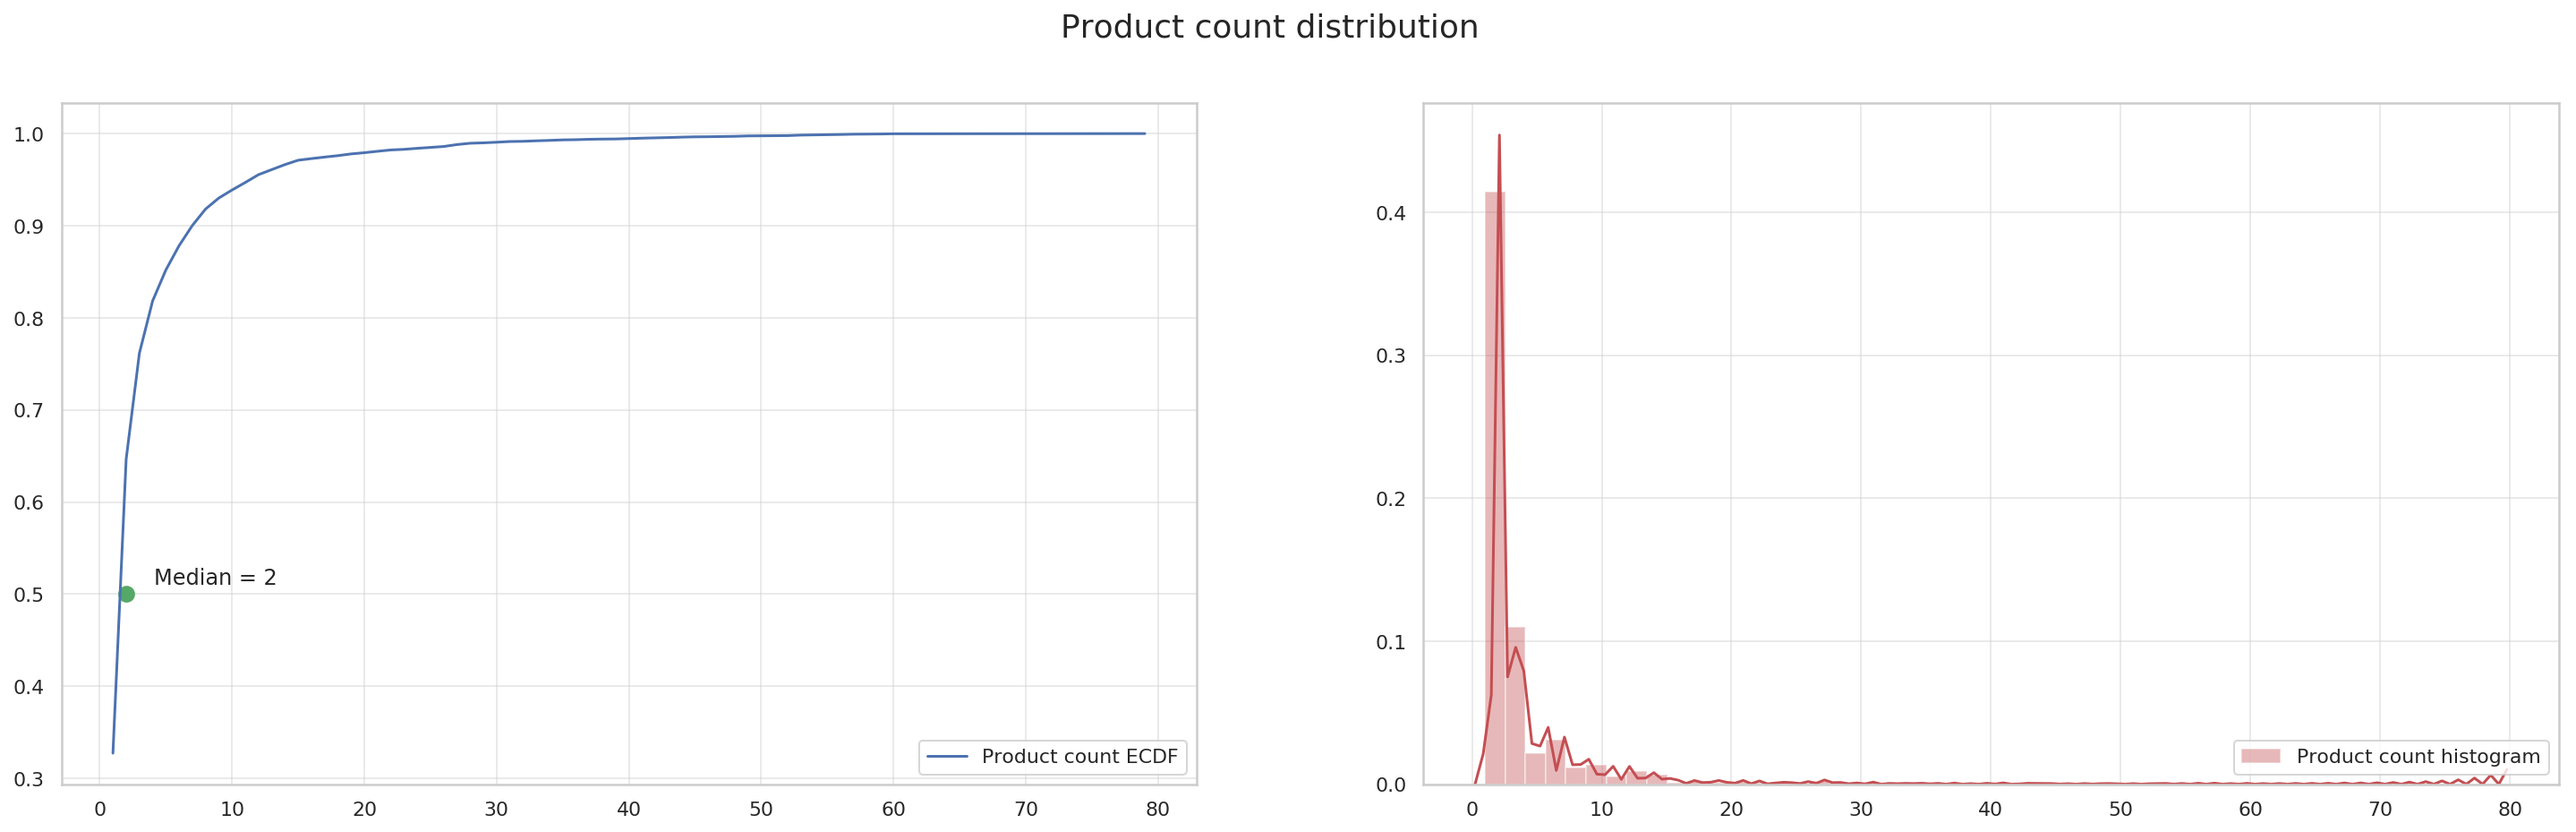

In [26]:
product_counts = df1.id.value_counts().sort_values().values
plot_column_distribution(product_counts, name="Product count")

The majority of the brands has less than 10 products listed. We can easily see outliers with very high product counts, going up to 1400

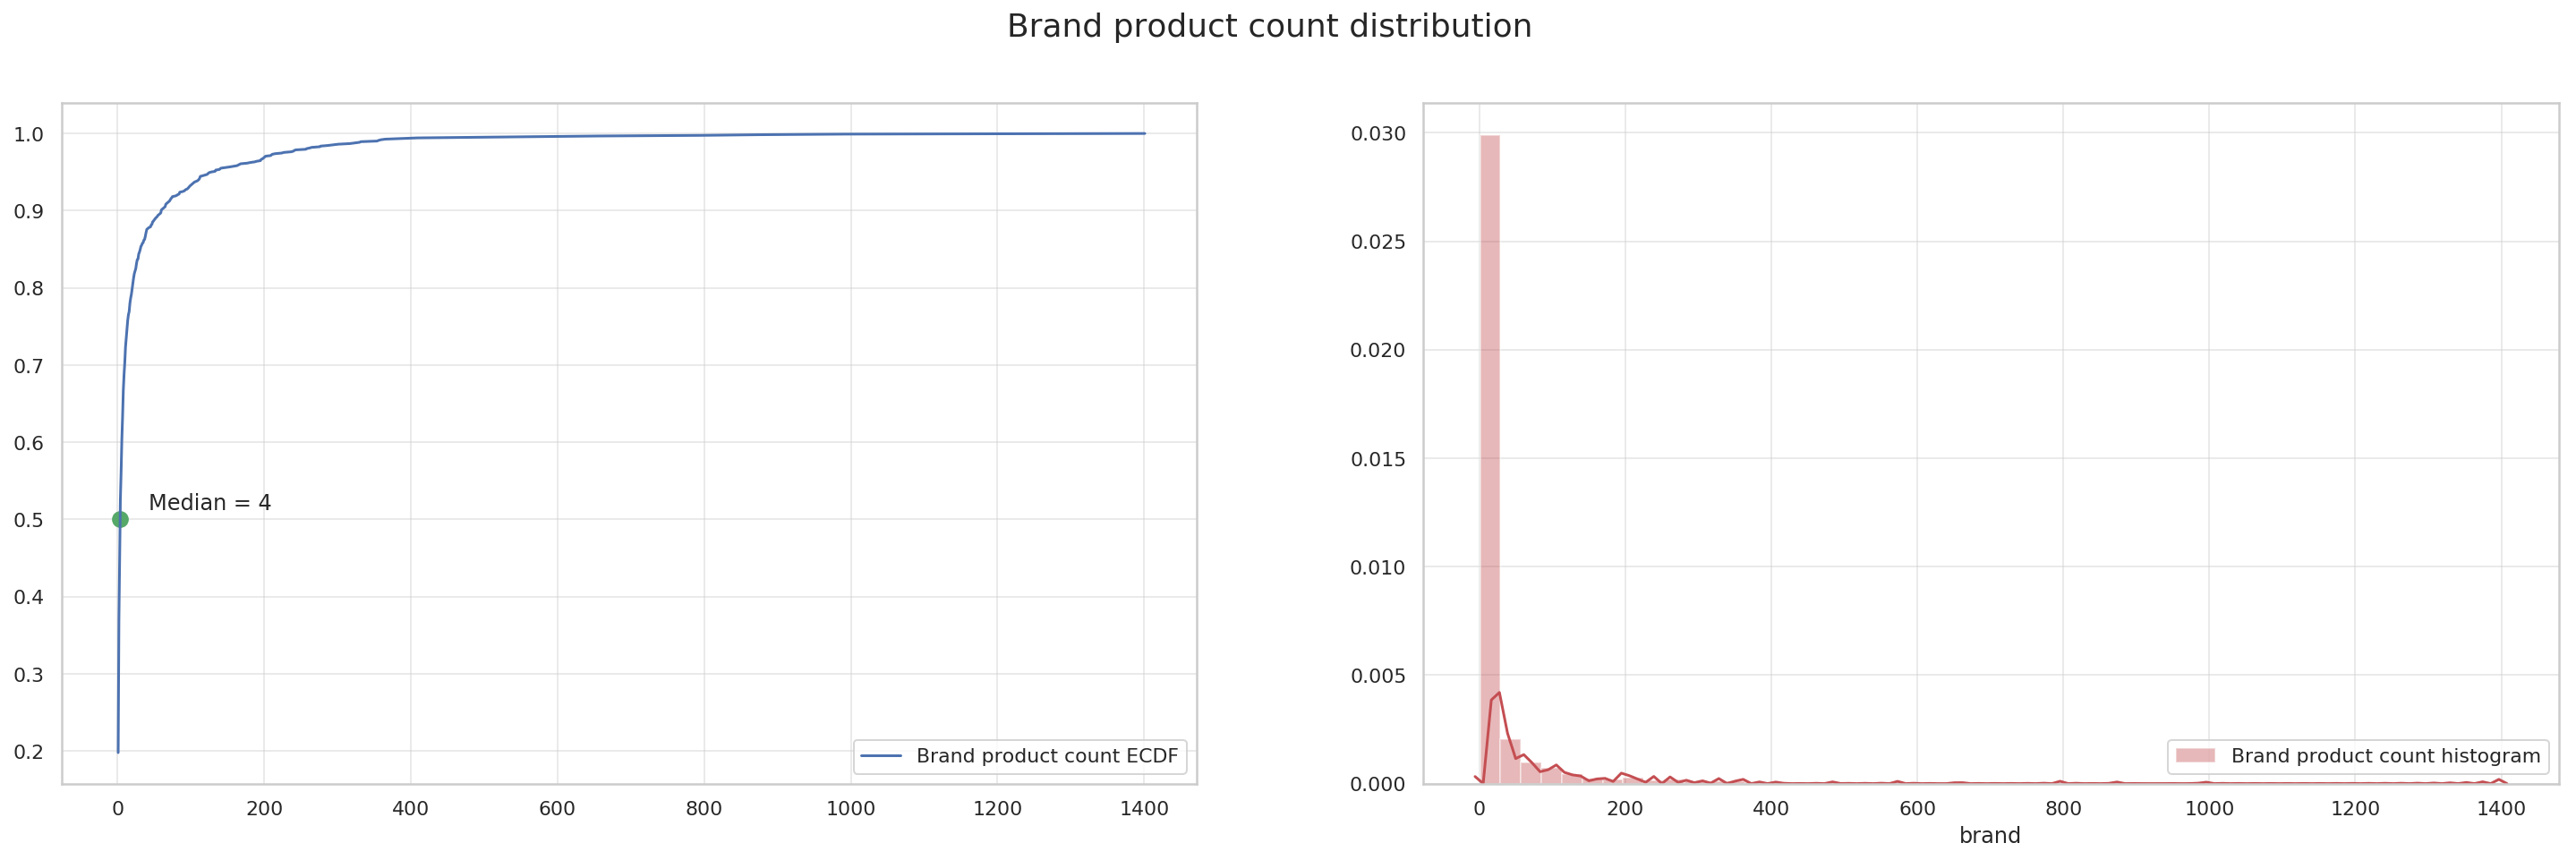

In [27]:
brand_dist = df1.brand.dropna().str.lower().value_counts()
plot_column_distribution(brand_dist, name="Brand product count")

We can check that approx. 90% of the products have their mean prices bounded in the interval 0 - 500 USD, and few outliers with very high prices, but they're less than 2% of our dataset

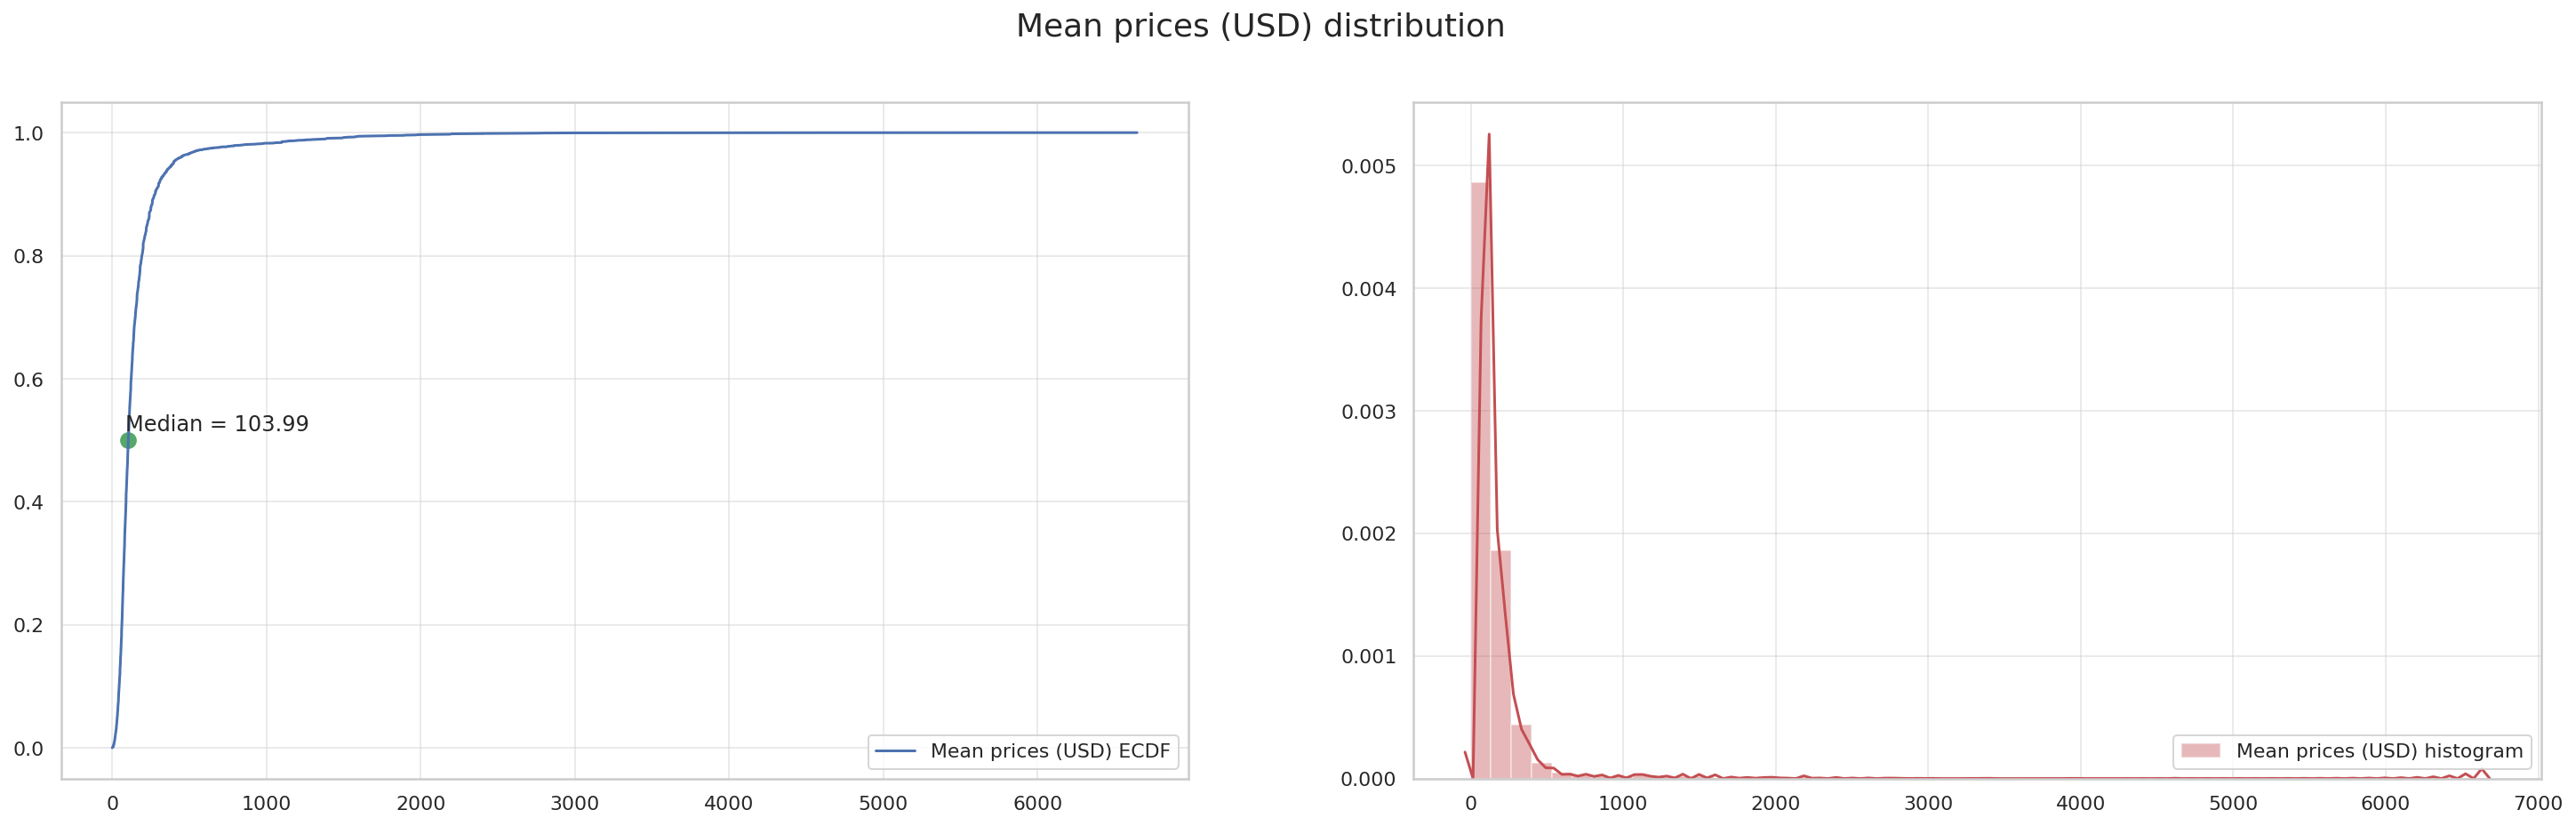

In [28]:
prices_dist = df1.groupby("id").apply(lambda g: (g.prices_amountMin + g.prices_amountMax).mean()).sort_values().values
plot_column_distribution(prices_dist, name="Mean prices (USD)")


The Brand price-ratio is basically a measure of how valuable are the products of a given brand. In the histogram we can see that there's a split in brand value, which decreases very fast. Again, there's some outliers (brands with very high price-ratio).

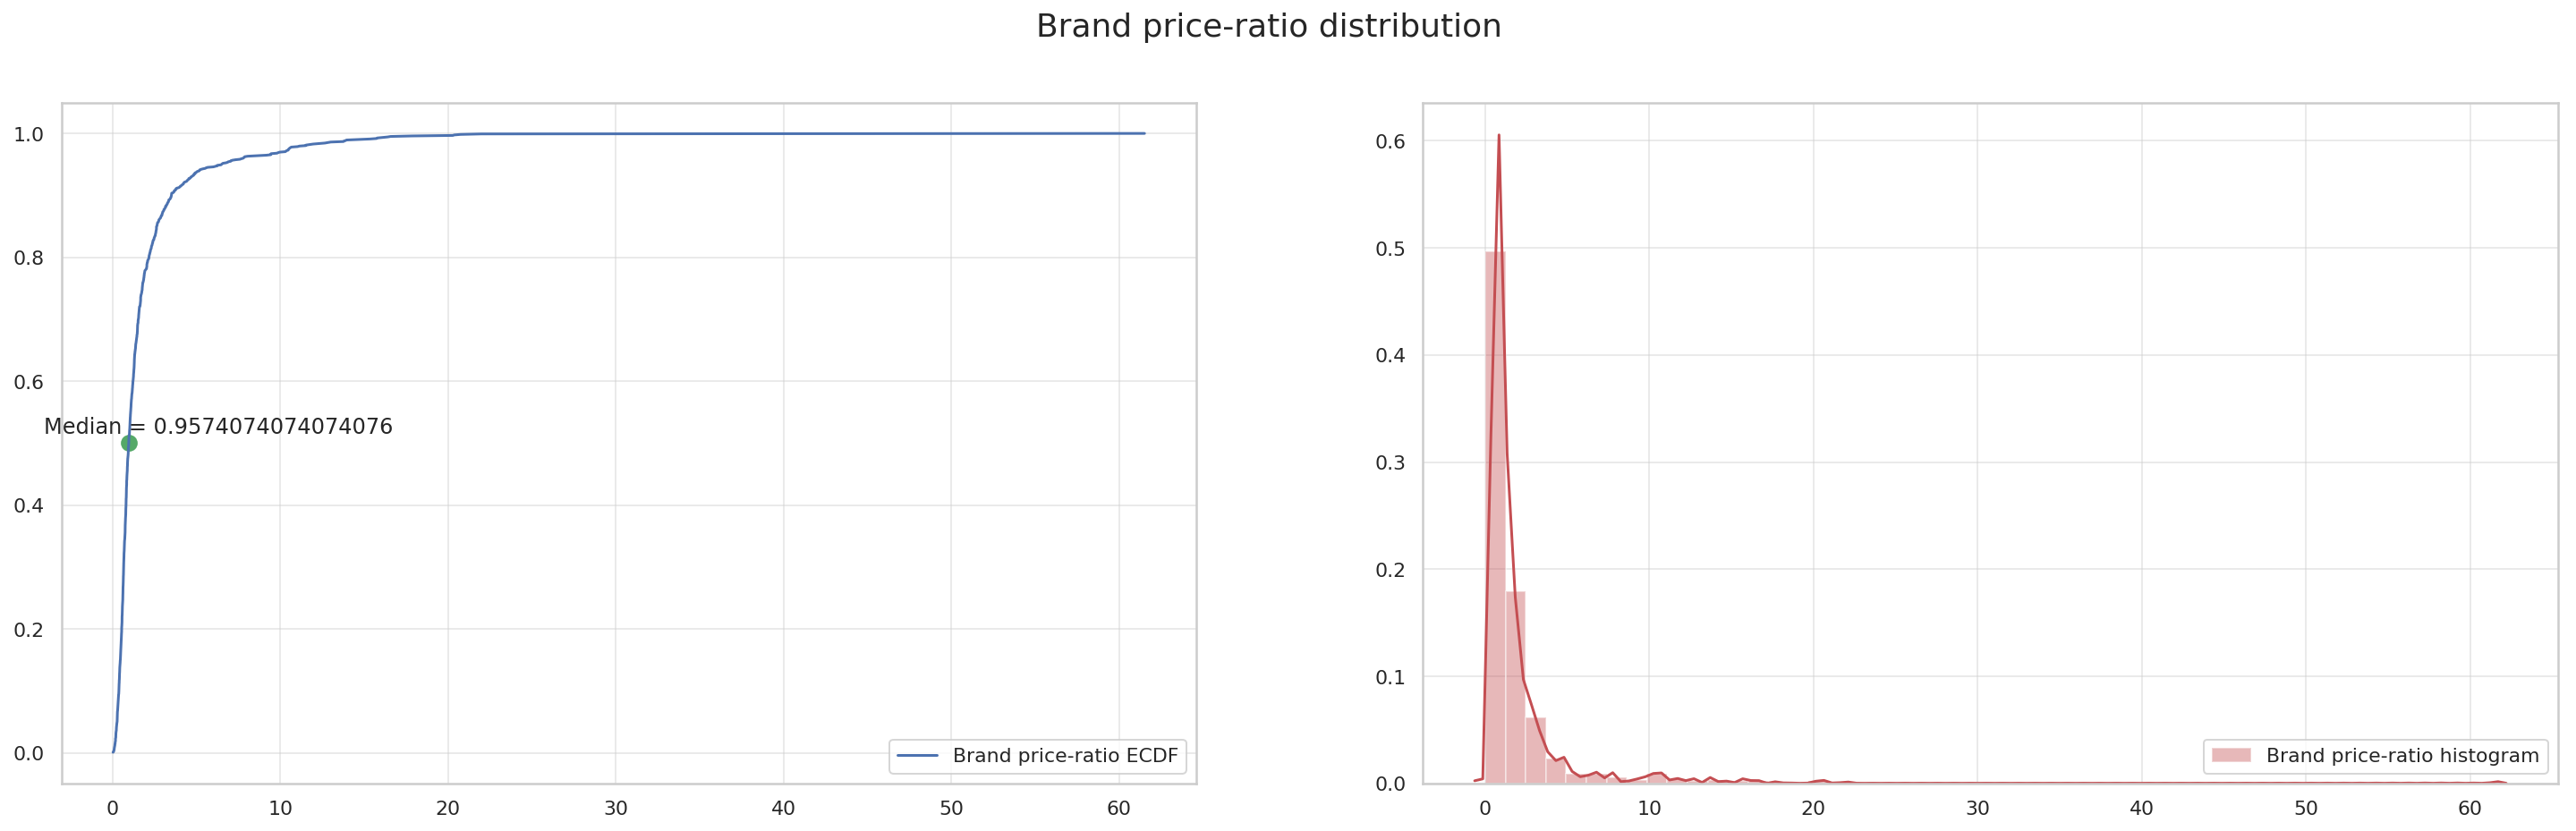

In [29]:
brand_price_ratio = (
    df1.assign(lower_brand=lambda df: df.brand.str.lower())
    .groupby("lower_brand")
    .apply(lambda g: g.prices_amountMax.sum() / g.size)
    .sort_values()
    .values
)
plot_column_distribution(brand_price_ratio, name="Brand price-ratio")

The Brand price delta is a measure of variability inside each brand product prices, in absolute value. It's basically the difference between the most expensive product and the cheapest product of the brand. We can check that the median is 50, which means a difference of 50 USD of prices within a brand.

There's also some outliers with very high price delta; It's a little strange to have a brand that offers products with very high cost and some with very low cost

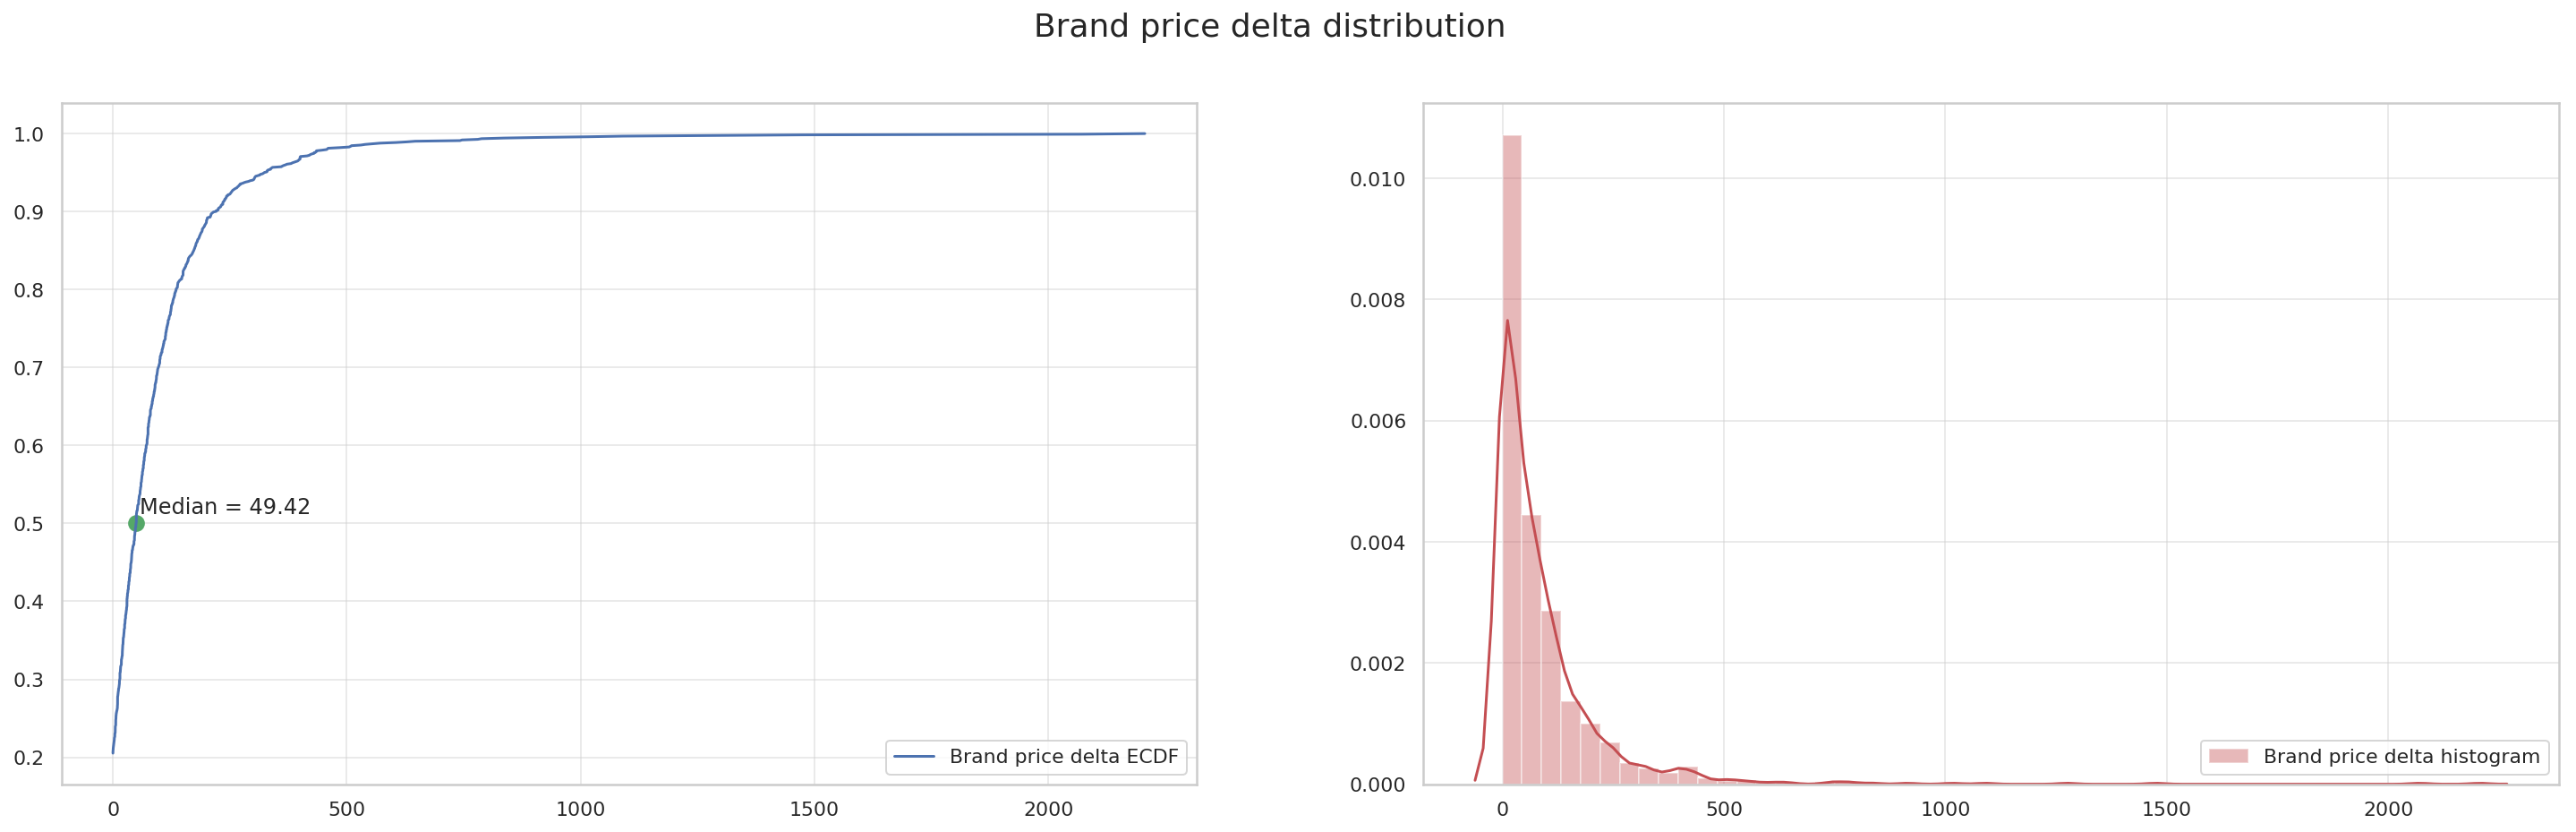

In [30]:
brand_price_delta = (
    df1.assign(lower_brand=lambda df: df.brand.str.lower())
    .groupby("lower_brand")
    .apply(lambda g: g.prices_amountMax.max() - g.prices_amountMin.min())
    .sort_values()
    .values
)
plot_column_distribution(brand_price_delta, name="Brand price delta")

I could check the above by merchant-wise aggregations, but I think those distributions shown above are enough to given an idea of the dataset itself.

### 3. Some categories evaluation

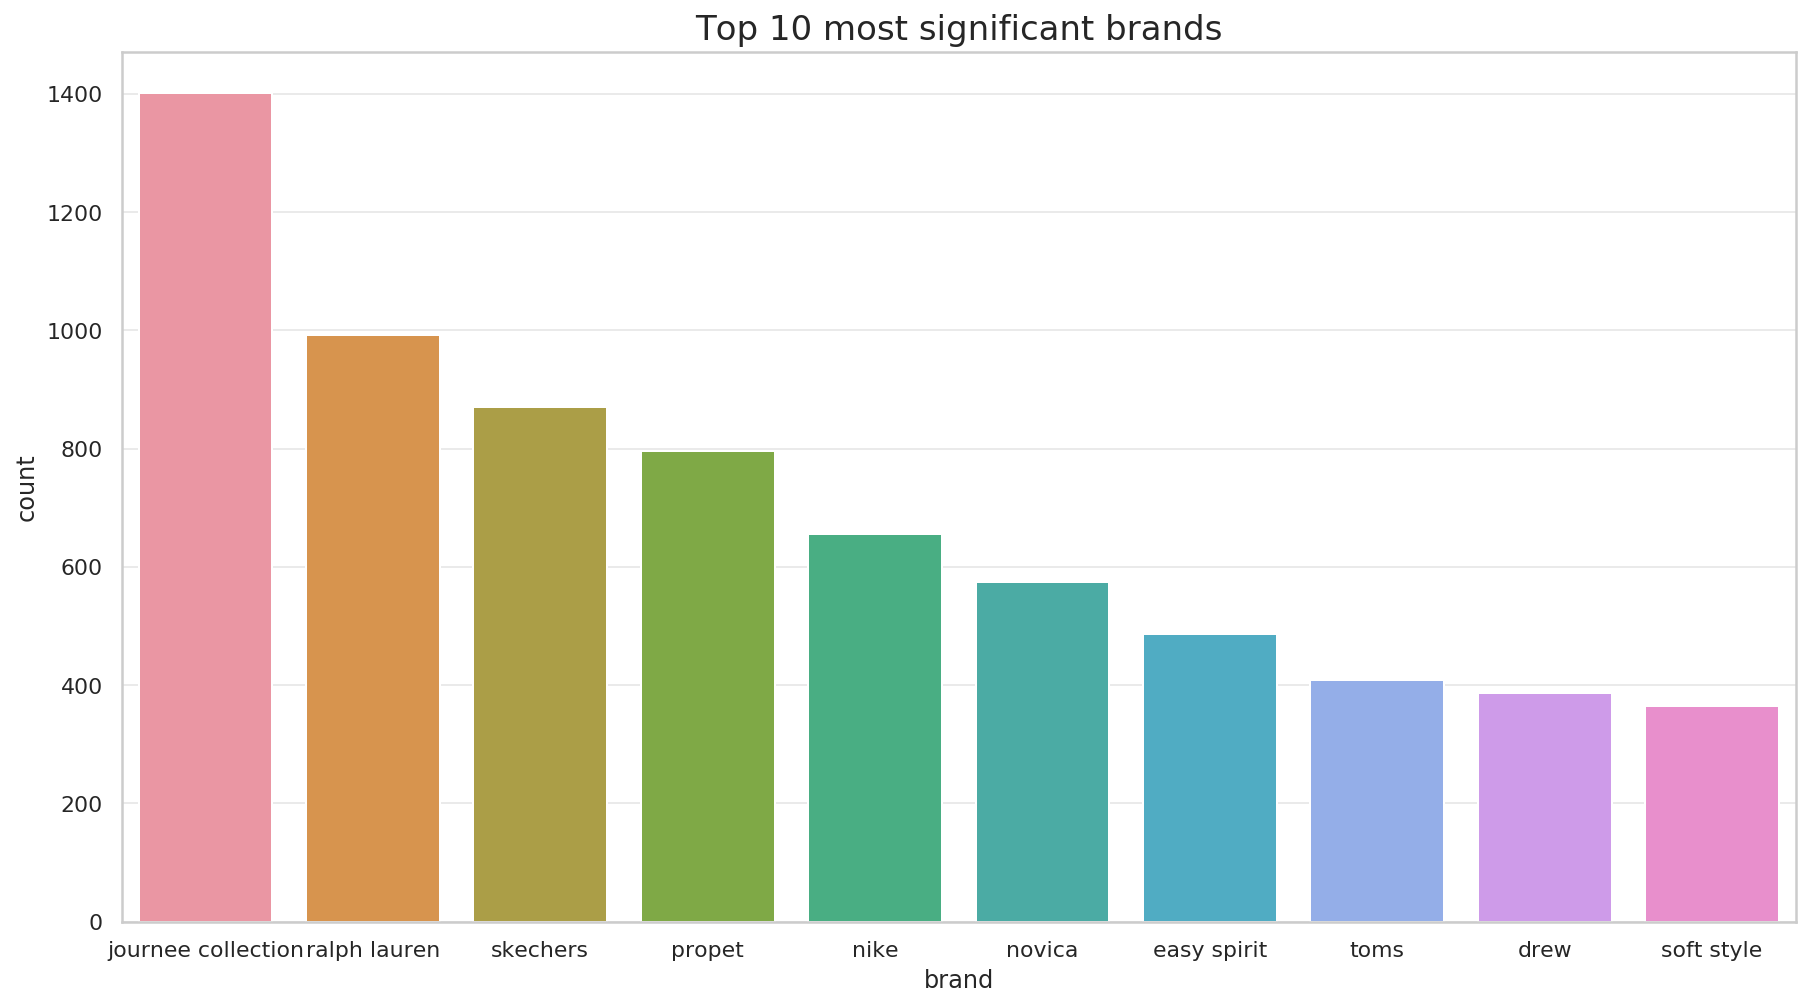

In [31]:
sns.barplot(
    x="brand",
    y="count",
    data=df1.lower_brand.value_counts()
    .head(10)
    .reset_index()
    .rename(columns={"index": "brand", "lower_brand": "count"}),
    ax=new_axis(title="Top 10 most significant brands"),
)

TOP 10 frequent colors

#### Most significant colors in the dataset

In [32]:
list_colors = (
    df1.explode("list_colors")
    .list_colors.value_counts()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={"index": "color", "list_colors": "count"})
    .color.values
)
matplot_colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)


def find_best_color_match(c):
    return sorted(matplot_colors.items(), key=lambda tup: -fuzz.ratio(tup[0], c))[0][1]


custom_palette = list(map(find_best_color_match, list_colors))

AttributeError: 'DataFrame' object has no attribute 'explode'

In [ ]:
sns.set_context(rc = {'patch.linewidth': 1.0})
sns.barplot(
    x="color",
    y="count",
    data=df1.explode("list_colors")
    .list_colors.value_counts()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={"index": "color", "list_colors": "count"}),
    palette=sns.color_palette(custom_palette),
    ax=new_axis(title="Top 10 most frequent colors"),
    edgecolor='k'
);


#### (Question 6) Mean price by month

In [ ]:
fig, ax = plt.subplots(figsize=(25, 10))
g = sns.barplot(
    x="month",
    y="mean_price",
    data=df1.groupby(pd.to_datetime(df1.dateAdded).dt.month)
    .apply(lambda df: df.prices_amountMax.mean())
    .reset_index()
    .rename(columns={"dateAdded": "month", 0: "mean_price"}),
    ax=ax,
)
ax.set_title("Mean price by date")

656 Shoes have a different price! TODO

#### (Question 5)

In [ ]:
df1.query("prices_amountMax - prices_amountMin > 0.0").id.size

## 5. Remarks and extra analysis

#### Most significant brands in the dataset

By checking the TOP 25 brands with the highest price ratio and price delta, we see that the first one, `jewelsobsession`, is 1st in both of them. by name, I don't think this sells shoes only, so I'll check manually the names of the product it sells and visualize it.

It's also worth noting that `jewelsobsession` is an outlier of the **price_ratio** variable, which indicates that its products are the ones with the highest prices.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 15))
sns.barplot(
    x="price_ratio",
    y="lower_brand",
    data=df1.groupby("lower_brand")
    .apply(lambda g: g.prices_amountMax.sum() / g.size)
    .rename("price_ratio")
    .sort_values(ascending=False)
    .reset_index().head(25),
    ax=ax[0],
    orient="h"
)

sns.barplot(
    x="price_delta",
    y="lower_brand",
    data=df1.groupby("lower_brand")
    .apply(lambda g: g.prices_amountMax.max() - g.prices_amountMin.min())
    .rename("price_delta")
    .sort_values(ascending=False)
    .reset_index().head(25),
    ax=ax[1],
    orient="h"
)

ax[0].set_title("Price Ratio"), ax[1].set_title("Price Delta");

By the name of it, these products do not seem to be shoes...

In [ ]:
df1.query("lower_brand == 'jewelsobsession'").name

#### (Question 1)

We'll now check by product category the prices and the frequency of each category.

We see that the highest price averages are related to jewelry (so this dataset doesn't contains only shoes >:( ), designer specific products, collections, etc; Which does makes sense.

However when checking the frequency of each category, we see that the majority of them are shoes, and doesn't appear a lot in the most expensive categories

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 15))

sns.barplot(
    x="prices_avg",
    y="list_categories",
    data=(
        df1.explode("list_categories")
        .groupby("list_categories")
        .apply(lambda g: g.prices_amountMax.mean())
        .sort_values(ascending=False)
        .iloc[:25]
        .rename("prices_avg").reset_index()
    ),
    orient="h",
    ax=ax[0]
)
sns.barplot(
    x="category_freq",
    y="list_categories",
    data=(
        df1.explode("list_categories")
        .groupby("list_categories").id
        .count()
        .sort_values(ascending=False)
        .iloc[:25]
        .rename("category_freq").reset_index()
    ),
    orient="h",
    ax=ax[1]
)
ax[0].set_title("Average of price by category"), ax[1].set_title("Frequency of category in the dataset");

What are the categories that most appear in the highest price ratio brands?

We see again that there's fine goods, designer shoes, designer collections, jewelry, etc!

#### (Question 2) Colors

One interesting thing I want to check is how are the colors of the products depending on the price.
Here I do a fuzzy matching to try to get the correct color and plot some of them.

In [ ]:
import functools
import operator
import string
from matplotlib import colors as mcolors
from fuzzywuzzy import fuzz


def flatlist(a):
    return functools.reduce(operator.concat, a)

 # INSTALL python-Levenshtein!!!
def colors_grad(df):
    # return the relative frequency of each color of a brand
    list_colors = df.list_colors.dropna().values
    matplot_colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

    def find_best_color_match(c):
        return sorted(matplot_colors.items(), key=lambda tup: -fuzz.ratio(tup[0], c))[0][1]

    if len(list_colors) > 0:
        list_colors = list(
            map(
                lambda x: x.replace(" ", "").translate(str.maketrans("", "", string.punctuation)), flatlist(list_colors)
            )
        )
        return {find_best_color_match(color): list_colors.count(color) for color in list_colors}
    return np.nan
brands_color_map = df1.groupby("lower_brand").apply(colors_grad).dropna().rename("color_map").reset_index()

In [ ]:
from collections import Counter
from functools import reduce
def sum_all_colors(df):
    return reduce(lambda x, y: Counter(x) + Counter(y), df.color_map.values)

In [ ]:
dataset_with_color_map = df1.merge(brands_color_map.dropna(), on="lower_brand", how="inner").query("lower_brand != 'unbranded'")
most_expensive_brands = dataset_with_color_map.groupby("lower_brand").apply(lambda x: x.prices_amountMax.mean()).sort_values(ascending=False).iloc[:100].index
least_expensive_brands = dataset_with_color_map.groupby("lower_brand").apply(lambda x: x.prices_amountMax.mean()).sort_values().iloc[:100].index

In [ ]:
most_expensive_colors = sum_all_colors(brands_color_map.query("lower_brand in @most_expensive_brands"))
least_expensive_colors = sum_all_colors(brands_color_map.query("lower_brand in @least_expensive_brands"))

In [ ]:
def plot_color_barplot(df, title):
    df_aux = pd.DataFrame(sorted(list(df.items()), key=lambda t: -t[1])[:20], columns=["hex", "count"])
    sns.set_context(rc={"patch.linewidth": 1.0})
    sns.barplot(
        x="hex",
        y="count",
        data=df_aux,
        palette=sns.color_palette(df_aux.hex.values),
        ax=new_axis(figsize=(25, 10), title=title),
        edgecolor="k",
    )

In [ ]:
plot_color_barplot(least_expensive_colors, title="Colors count for the least expensive brands (approximate)")

In [ ]:
plot_color_barplot(most_expensive_colors, title="Colors count for the most expensive brands (approximate)")

Black and Brown are the most predominant colors. From this approximate plot, it seems like the least expensive brands have more pink, red and blue; One reason for this can be the presence of athletics products, which usually have this color.

#### (Question 3) Reviews

I wanted to know which brands have the best and the worst reviews, so I'm checking this here!

However, please note that from all the 30k rows, only about 2k of them have reviews, and a lot of products also have some NaN ratings, so this analysis applies only to a subset of the women's shoes dataset!

Nonetheless, the brands I found are mostly unknown. For example, from those I only know Asics.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 15))

brand_mean_ratings = (
    df1[df1.review_ratings.notna()]
    .assign(
        mean_rating=lambda df: df.review_ratings.apply(
            lambda list_e: np.mean(list(filter(lambda el: not np.isnan(el), list_e)))
        )
    )
    .groupby("id")
    .first()
    .groupby("lower_brand")
    .apply(lambda df: np.mean(df.mean_rating))
    .rename("brand_mean_rating")
    .reset_index()
    .sort_values(by="brand_mean_rating")
    .query("brand_mean_rating < 5")


)
print(brand_mean_ratings.shape)
sns.barplot(x="brand_mean_rating", y="lower_brand", data=brand_mean_ratings.iloc[:25], ax=ax[0])
sns.barplot(x="brand_mean_rating", y="lower_brand", data=brand_mean_ratings.iloc[-25:], ax=ax[1])
ax[0].set_title("Brands with lowest average ratings"), ax[1].set_title("Brands with highest average ratings");

#### (Question 4)

In order to verify if the products information were updated with time, and not just added by the group making the datase, it is important to know what is the percentage of entries that have different costs. It is expected that the percentage is somewhat large for products available for a long time, because it is common for product's prices to change.

Since the dataframe is not mantained, oldest update is in 2017, let's assume that a old value is one that is older than the median of the dateAdded column. Another observation is that it is expected that products will very fast stop being fabricated, so it is not expected that their price change date range will be large.

Next, we check this information:
0. Get median of dateAdded values.
1. We get all the products that are available for longer than the median (ids). (This is meant to give a bound for the hypotesis that the prices should change if they are old)
2. From these products we check those that have more than one entry. 
3. From the one's that changed we check those whose amountMax or amountMin changed. 

In [ ]:
#calculates median - all values from 2017 or before
def getDate(entry):
    sDate = entry["dateAdded"]
    def age(date):
        return 100 * (int(date[0:4]) - 2010)
    def getMonth(date):
        d = int(date[5:7])
        return d
    val = 0
    val += age(sDate)
    val += getMonth(sDate)
    return val

median = np.median(df1.assign(numDate=lambda df: df.apply(getDate, axis=1)).numDate.values)

def isOld(date):
    return getDate(date) < median #conservative (does not include products with the same year/month as the median)

def category_is_old(df):
    return any(df["is_old"].values)

def category_is_large(df):
    return df.shape[0] > 1

def price_is_changed(df):
    return (df.prices_amountMin.value_counts().size != 1) | (df.prices_amountMax.value_counts().size != 1)


(
    df1.assign(is_old=lambda df: df1.apply(isOld, axis=1))
            .groupby("id")
            .filter(category_is_old)
            .groupby("id")
            .filter(category_is_large)
            .groupby("id")
            .apply(price_is_changed).value_counts()    
)

From this analysis we know that almost all shoes were updated in this dataframe. Since few were not, and it is expected that some shoes stop being fabricated, we can trust that companied updated their prices in this set, as they were changed.

## Remaining Questions
For the remaining questions:

6) Is there any symmetry that can be stressed?

    Not that I found out. The only I found is between luxury products / brands and higher prices, but this is already expected.

7) How important was EDA to help you understand the dataset?

    Very important, especially because this dataset is very dirty and needs a lot of cleaning :/